In [1]:
import torch
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [27]:
class SpinConfiguration:
    def __init__(self, N, values):
        self.N = int(N)
        self.values = values
        self.energy = None

    @property
    def values(self):
        return self._values
    
    @values.setter
    def values(self, values):
        if type(values) is np.ndarray:
            values = torch.tensor(values, dtype=torch.float32)
        elif type(values) is torch.Tensor:
            values = values.to(torch.float32)
        else:
            raise RuntimeError(f"Values are in {type(values)} format.")
        
        if torch.logical_or(values==-1, values==1).all():
            self._values = values
        else:
            raise RuntimeError(f"Some spin values are not -1 or 1.")
            
    @classmethod
    def create_random(cls, N):
        values = torch.rand(N, N) * 2 - 1
        values[values<0] = -1
        values[values>=0] = 1
        return cls(N, values=values)
    
    def get_energy(self, J):
        energy = -self.values.flatten() @ J @ self.values.flatten()
        return energy
    
    def mc_step(self, T, J, current_energy=None):
        E0 = self.get_energy(J) if current_energy is None else current_energy
        
        # Choose random spin and flip it
        idx0, idx1 = torch.randint(self.N, (1,)), torch.randint(self.N, (1,))
        self.values[idx0, idx1] *= -1
        
        # Get energy of new state
        Et = self.get_energy(J)
        
        deltaE = Et - E0
        if deltaE <= 0:
            return Et
        else:
            # Arranger les unités
            beta = 1/T
            p = torch.exp(-beta*deltaE)
            a = np.random.rand()
            if a < p:
                return Et
            else:
                self.values[idx0, idx1] *= -1
                return E0
            
    def thermalize(self, J, T=5, nstep=10000):
        for i in range(nstep):
            self.energy = self.mc_step(T=T, J=J, current_energy=self.energy)
            
    def get_magnetization(self):
        mag = torch.mean(self.values)
        return mag

In [3]:
def create_adjacency_matrix(N):
    offdi_list = [0, 1]
    for _ in range(N-3):
        offdi_list.append(0)
    offdi_list.append(1)

    offdi_mat = scipy.linalg.circulant(offdi_list)
    I = np.eye(N)
    
    A = np.kron(offdi_mat,I) + np.kron(I,offdi_mat)
    return A

def create_J_matrix(N, sigma=1):
    A = create_adjacency_matrix(N)
    J = sigma * A
    return torch.tensor(J, dtype=torch.float32)

### Ferro example

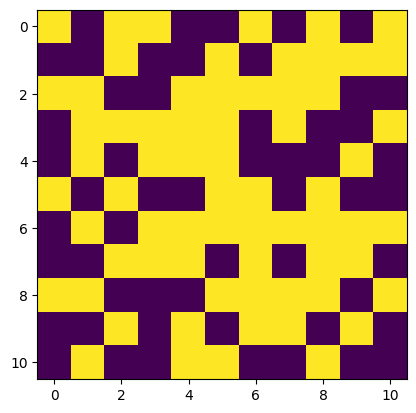

In [35]:
J = create_J_matrix(11, sigma=1)
sp1 = SpinConfiguration.create_random(11)
plt.imshow(sp1.values)

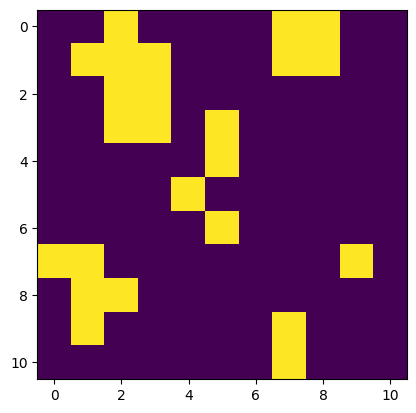

In [36]:
sp1.thermalize(J=J, nstep=10000)
plt.imshow(sp1.values)

### Antiferro example

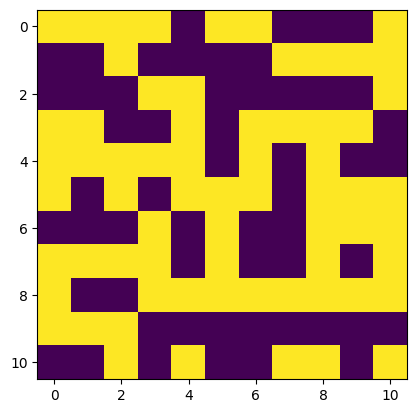

In [29]:
J = create_J_matrix(11, sigma=-1)
sp1 = SpinConfiguration.create_random(11)
plt.imshow(sp1.values)

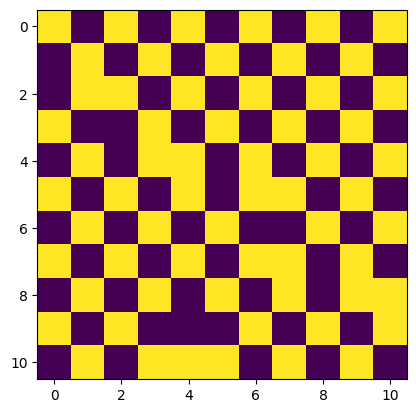

In [30]:
sp1.thermalize(J=J, nstep=10000)
plt.imshow(sp1.values)